In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyTVDN.tmpUtils import *
from scipy.signal import lfilter, firls, decimate
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def SmoothEst(self):
        if self.nYmat is None:
            self._Preprocess()
        d, n = self.nYmat.shape
        acTime = n / self.paras.freq
        self.ptime = np.linspace(0, acTime, n)
        self.time = np.linspace(0, self.paras.T, n)
        divNum = 100
        if self.smoothType == "bspline":
            self.dXmat = np.zeros((d, n))
            self.Xmat = np.zeros((d, n))
            if n%divNum == 0:
                numLoop = int(n/divNum)
            else:
                numLoop = int(n/divNum) + 1
            for i in range(numLoop):
                if (i+1)*divNum <= n:
                    low = i*divNum
                    up = (i+1)*divNum
                else:
                    low = i*divNum
                    up = n
                self.dXmat[:, low:up], self.Xmat[:, low:up] = GetBsplineEst(self.nYmat[:, low:up], self.time[low:up], 
                                                                            lamb=self.paras.lamb)
        elif self.smoothType == "fourier":
            self.dXmat, self.Xmat = GetFourierEst(self.nYmat, self.time, nbasis=self.paras.nbasis)
            

In [4]:
resDir = Path("../results")
dataDir = Path("../data/MEG-resting-state")

In [5]:
datFil = list(dataDir.glob("*8008*min.mat"))[0]
print(datFil)

MEG = loadmat(datFil)
data = MEG["DK_timecourse"]
data.shape

../data/MEG-resting-state/lcmv_result_8008-101_wo_filtering_min.mat


(68, 35999)

The time course is 60 seconds, so the frequency is 600 Hz

###  Data preprocessing

In [6]:
q = 5
dataN = decimate(data, q=q)
dataN = detrend(dataN)

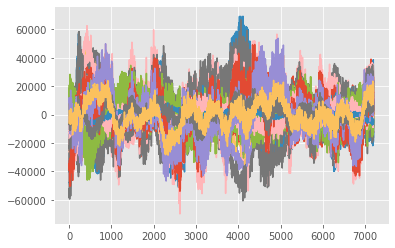

In [7]:
d, n = dataN.shape
for i in range(d):
    plt.plot(dataN[i, :])

### Tuning kappa

In [8]:
paras = edict()
paras.Lmin = 200
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = None
paras.freq = 120
paras.lamb = 1e-2
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = 2.77
paras.downRate = 20

detObjs = []
for i in range(5):
    dataPart = data[:, i::5]
    dataPart = detrend(dataPart)
    detPart = TVDNDetect(Ymat=dataPart, dataType="MEG", 
                         saveDir=None, #"MEGst02", 
                         fName="MEG1",
                         showProgress=True, 
                         MaxM=paras.MaxM,
                         Lmin=paras.Lmin, 
                         lamb=paras.lamb, 
                         kappa=paras.kappa, 
                         freq=paras.freq,
                         r=paras.r,
                         T=paras.T,
                         is_detrend=paras.is_detrend,
                         decimateRate=paras.decimateRate, 
                         downRate=paras.downRate)
    detPart.Screening(wh=paras.wh)
    detPart()
    kappas = np.arange(1, 4, 0.001)
    detPart.TuningKappa(kappas)
    detObjs.append(detPart)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}



The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.77,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}


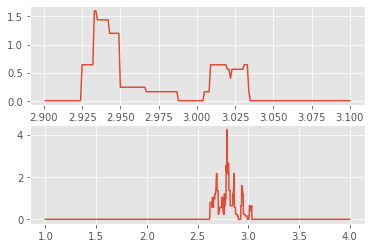

In [9]:
numchgss = []
for i in range(5):
    numchgs = detObjs[i].numchgs
    numchgss.append(numchgs)
    
numchgssArr = np.array(numchgss)
varsAll = np.var(numchgssArr, axis=0)

kpidxs = ((kappas >= 2.9).astype(np.int) + (kappas<=3.1)) == 2
subVarsAll = varsAll[kpidxs]
subKappas = kappas[kpidxs]

plt.subplot(211)
plt.plot(subKappas, subVarsAll)
plt.subplot(212)
plt.plot(kappas, varsAll)

In [10]:
optKaIdx = np.argmin(subVarsAll)
optKappa = subKappas[optKaIdx]
print(optKappa)

2.9009999999997906


## Detection on data with screening and no HPF

In [21]:
paras = edict()
paras.Lmin = 200
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = None
paras.freq = 120
paras.lamb = 1e-2
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = optKappa
paras.downRate = 20

In [12]:
detRaw = TVDNDetect(Ymat=dataN, dataType="MEG", 
                     saveDir=None, #"MEGst02", 
                     fName="MEG1",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.9009999999997906,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}


In [13]:
detRaw.Screening(wh=paras.wh)
detRaw()

Sequences after B-spline

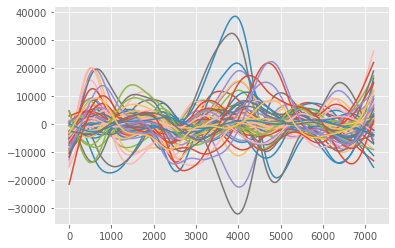

In [14]:
for i in range(detRaw.Xmat.shape[0]):
    plt.plot(detRaw.Xmat[i, :])

+-------------+----------------------------+-------------------+------+
| Num of CPTs |       Estiamted CPTs       |        MSE        | Rank |
+-------------+----------------------------+-------------------+------+
|      5      | [1053 3778 4550 6282 6744] | 6.644655770715648 |  4   |
+-------------+----------------------------+-------------------+------+


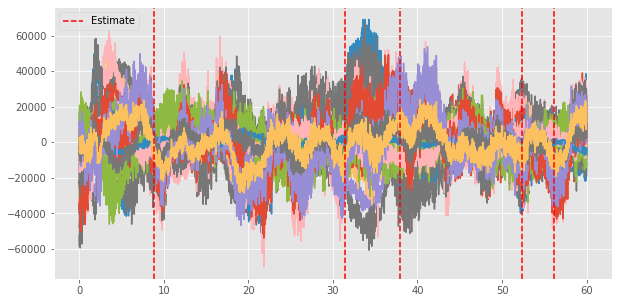

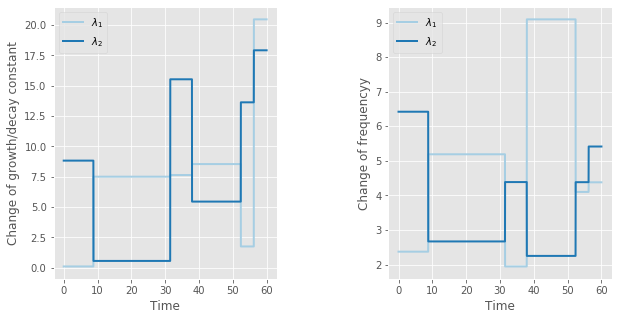

In [15]:
print(detRaw)
detRaw.PlotEcpts()
detRaw.PlotEigenCurve()


In [16]:
np.diff(detRaw.ecpts)

array([2725,  772, 1732,  462])

### Detection without Screening

In [22]:
detRawNo = TVDNDetect(Ymat=dataN, dataType="MEG", 
                     saveDir="MEG-RSN-rankada", #"MEGst02", 
                     fName="MEG-RS8008",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG-RS8008',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 2.9009999999997906,
 'lamb': 0.01,
 'nbasis': 10,
 'r': None}


In [23]:
detRawNo()


Save Main Results at MEG-RSN-rankada/MEG-RS8008_RankNone.pkl.


+-------------+----------------------------+-------------------+------+
| Num of CPTs |       Estiamted CPTs       |        MSE        | Rank |
+-------------+----------------------------+-------------------+------+
|      5      | [1040 3767 4549 6252 6761] | 6.118391405967165 |  4   |
+-------------+----------------------------+-------------------+------+


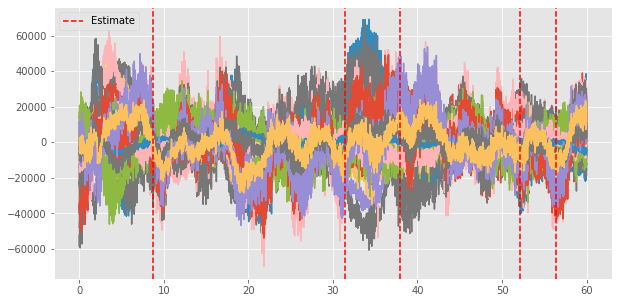

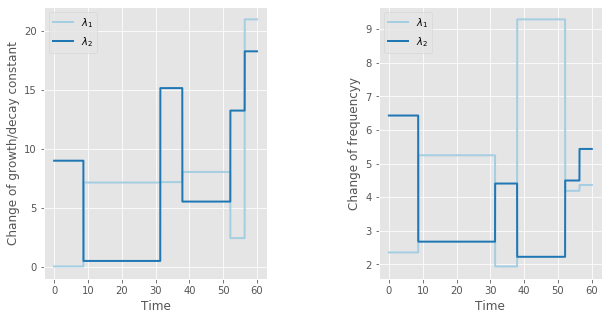

In [30]:
print(detRawNo)
detRawNo.PlotEcpts()
detRawNo.PlotEigenCurve()

### Save results

In [25]:
def obtainwU(DetObj):
    eigVecs = DetObj.midRes.eigVecs[:, :DetObj.paras.r]
    kpidxs = np.concatenate([[0], DetObj.ecpts]).astype(np.int)
    eigVals = DetObj.RecResCur.LamMs[:, kpidxs]
    wU = eigVecs.dot(eigVals)
    return wU

def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

In [26]:
wUst = obtainwU(detRawNo)
wUst = np.transpose(wUst)
abswUst = np.abs(wUst)
# save to npy file
with open("../results/MEG-RSN-wU/MEGRS8008_Screening_abswU_full.npy", "wb") as f:
    np.save(f, abswUst)
with open("../results/MEG-RSN-wU/MEGRS8008_Screening_wU_full.npy", "wb") as f:
    np.save(f, wUst)

abswUstMM = np.zeros_like(abswUst)
for i, col in enumerate(abswUst):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    abswUstMM[i, :34] = lh
    abswUstMM[i, 34:] = rh

In [27]:
import pandas as pd

fcR = pd.read_csv('../data/brain_plot_meg/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    lh = minmax(fcRar[:34])
    rh = minmax(fcRar[34:])
    fcRarrMM[i, :34] = lh
    fcRarrMM[i, 34:] = rh

In [28]:
from collections import OrderedDict as odict
csvD = odict()
for i, name in enumerate(colNames):
    csvD[name] = abswUstMM[:, i]

csvD = pd.DataFrame(csvD)
csvD.to_csv("../results/MEG-RSN-wU/wU_Screening_minmax_RS8008.csv")

In [29]:
import scipy.stats as ss
from collections import defaultdict as ddict
corrs = ddict(list)
for absU in abswUstMM:
    for j, name in enumerate(rowNames):
        corrs[name].append(ss.pearsonr(fcRarrMM[j, :], absU)[0])
        #corrs[name].append(ss.spearmanr(fcRarrMM[j, :], absU)[0])
    
corrsDF = pd.DataFrame(corrs)
corrsDF.to_csv("../results/MEG-RSN-wU/corrs_Screenig_RS8008.csv")
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.160470,0.600765,-0.116677,-0.296436,0.132909,-0.100684,0.171021
1,-0.246093,0.345057,0.021942,-0.220128,-0.074099,-0.074150,0.320342
2,-0.106279,0.572575,0.079232,-0.332407,0.174761,0.016805,-0.017319
3,-0.247839,0.195685,0.167937,-0.234949,-0.039153,-0.084876,0.291550
4,-0.084287,0.570381,-0.039226,-0.307259,-0.040190,-0.015271,0.205386
5,-0.072909,0.478376,0.145845,-0.304918,0.073995,0.110134,-0.022613


### Results of other methods

In [17]:
import rpy2.robjects as robj

robj.r.source("../Rcode/utils.R")
RsegCorr = robj.r["segCorr"]
RsegPCA = robj.r["segPCA"]
RsegDMD = robj.r["DMD"]
RchgF = robj.r["chgF"]
RsegDMDOrg = robj.r["DMDOrg"]
RsegPCAOrg = robj.r["segPCAOrg"]

In [18]:
ecptss = edict()
d, n = dataN.shape

paras = edict()
paras.rank = 0.8
paras.slidew = 40


wsizes = [200, 400, 600, 800, 1000]

for wsize in wsizes:
    ecpts = edict()
    paras.seqw = np.arange(1, n-wsize, paras.slidew)
    rSeqw = py2Rvec(paras.seqw)
    rYmat = py2Rmat(dataN)
    
    
    # Detection results for DCOR
    rDCORres = RsegCorr(rYmat, wsize, rSeqw)
    rDCORecpts = RchgF(rDCORres, rSeqw)
    ecpts.DCOR = np.array(rDCORecpts)
        
    # Detection results for PCA
    rPCAres = RsegPCA(rYmat, wsize, rSeqw, rank=paras.rank)
    rPCAecpts = RchgF(rPCAres, rSeqw)
    ecpts.PCA = np.array(rPCAecpts)
        
    # Detection results for DMD
    rDMDres = RsegDMD(rYmat, wsize, rSeqw, rank=paras.rank)
    rDMDecpts = RchgF(rDMDres, rSeqw)
    ecpts.DMD = np.array(rDMDecpts)
    
    ecptss[f'w{wsize}'] = ecpts

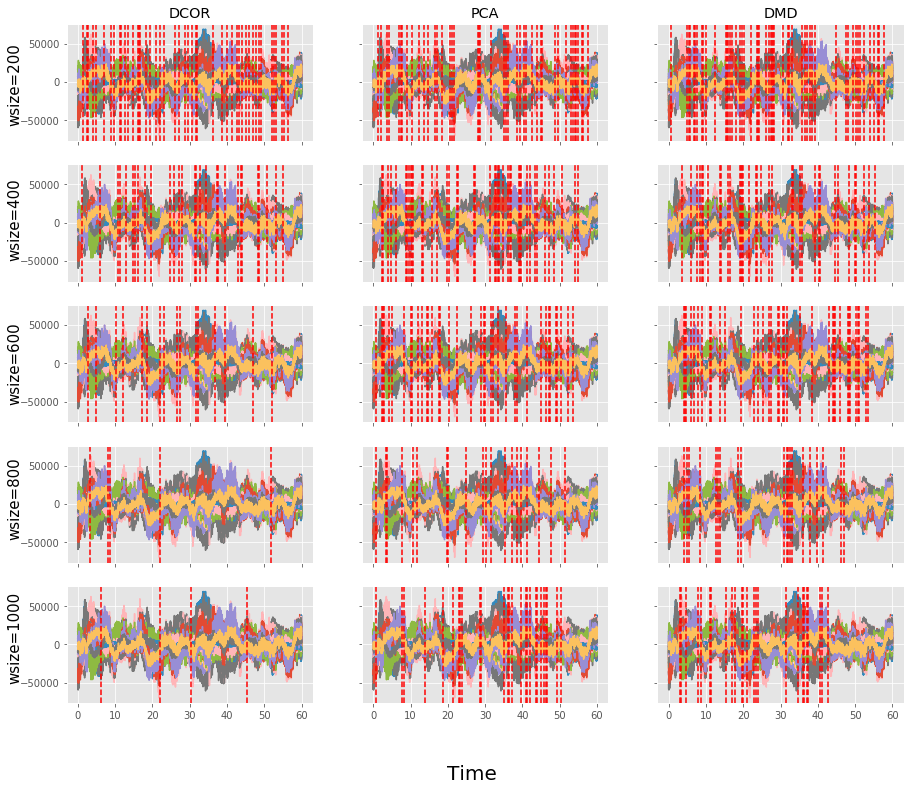

In [19]:
ptime = np.linspace(0, 60, n)
ajfct = n/60
names = ["DCOR", "PCA", "DMD"]

fig, axs= plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(15, 12.5))

for fi in range(5):
    for fj in range(3):
        for i in range(d):
            axs[fi, fj].plot(ptime, dataN[i, :])
        for ecpt in ecptss[f"w{wsizes[fi]}"][names[fj]]:
            axs[fi, fj].axvline(ecpt/ajfct, color="red", linestyle="--")
            
axs[0, 0].set_title("DCOR")
axs[0, 1].set_title("PCA")
axs[0, 2].set_title("DMD")


fig.text(0.5, 0.04, 'Time', ha='center', fontsize=20)
#fig.text(0.04, 0.5, 'Time', va='center', rotation="vertical", fontsize=20)
#
fig.text(0.07, 0.77, f"wsize={wsizes[0]}", rotation="vertical", fontsize=15)
fig.text(0.07, 0.62, f"wsize={wsizes[1]}", rotation="vertical", fontsize=15)
fig.text(0.07, 0.46, f"wsize={wsizes[2]}", rotation="vertical", fontsize=15)
fig.text(0.07, 0.31, f"wsize={wsizes[3]}", rotation="vertical", fontsize=15)
_ = fig.text(0.07, 0.15, f"wsize={wsizes[4]}", rotation="vertical", fontsize=15)